In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random
from random import randint
import time

In [2]:
FILE_NAME = "PQ2MON - Orders - Weeks -1 to -109 (1).xls.xlsx"
DF = pd.read_excel(FILE_NAME)
DF.head(5)

Client Grouping1     Customer Group Requested Mode  Priority  \
0        Corporate  3M Canada Company           ROAD  Standard   
1        Corporate  3M Canada Company           ROAD  Standard   
2        Corporate  3M Canada Company           ROAD  Standard   
3        Corporate  3M Canada Company           ROAD  Standard   
4        Corporate  3M Canada Company           ROAD  Standard   

  Requested Trailer Class Shipper Region3 Consignee Region3  \
0                     DRY          ON2TOR              PQ2S   
1                     DRY          ON2TOR              PQ2S   
2                     DRY          ON2TOR              PQ2S   
3                     DRY          ON2TOR              PQ2S   
4                     DRY          PQ2MON            USMWIA   

                      Lane ID - City to City Start Date Completion Date  \
0            MILTON,ON/ to DRUMMONDVILLE,PQ/ 2019-04-16      2019-04-18   
1            MILTON,ON/ to DRUMMONDVILLE,PQ/ 2019-05-07      2019-05-09   
2            MILTON,ON/ to DRUMMONDVILLE,PQ/ 2019-06-07      2019-06-10   
3            MILTON,ON/ to DRUMMONDVILLE,PQ/ 2019-07-09      2019-07-11   
4  STE THERESE,PQ/TE to PRAIRIE DU CHIEN,WI/ 2020-02-26      2020-03-02   

   Order #  Avg. Weekly Frequency  
0  3790088                      0  
1  3810953                      0  
2  3841144                      0  
3  3869973                      0  
4  4066936                      0

In [3]:
# Clean the irrelevant columns, only keeping the rows that has PQ data
# internal are orders that starts and completes within the PQ region itself.
# external are orders that goes from anyhwere in PQ to other region and vice versa
def get_df_clean(df,select=None,drop=["Customer Group","Requested Mode","Order #","Avg. Weekly Frequency","Lane ID - City to City","Client Grouping1"]):
    if drop_columns == None: drop_columns = ["Customer Group","Requested Mode","Order #","Avg. Weekly Frequency","Lane ID - City to City","Client Grouping1"]
    cond_out = df['Shipper Region3'].str.startswith(region)
    cond_in  = df['Consignee Region3'].str.startswith(region)
    df_clean = df[cond_out|cond_in].drop(columns=drop_columns)
    df_clean.loc[:,'Shipper Region3'].fillna("UNKNOWN",inplace=True)
    df_clean.loc[:,'Consignee Region3'].fillna("UNKNOWN",inplace=True)
    return df_clean

In [15]:
DAYS = pd.Timedelta(days=1)
DF_CLEAN = get_df_clean(DF)

In [ ]:
# Get the counts for a schedule, such as inbound and out bound figures. Also calculates the imbalance levels
def get_df_count(df,start_date=None,end_date=None,fill_missing=False,region='PQ'):
    if start_date == None: start_date = get_earliest(df,'Start Date')
    if end_date == None: end_date = get_latest(df,'Completion Date')
    df_out = df[df['Shipper Region3'].str.startswith(region)]['Start Date'].value_counts().sort_index(axis=0)
    df_in = df[df['Consignee Region3'].str.startswith(region)]['Completion Date'].value_counts().sort_index(axis=0)
    df_count = pd.concat([df_out, df_in],axis=1).fillna(0, downcast='infer').rename(columns={"Start Date": "Outbound", "Completion Date": "Inbound"})
    if fill_missing and start_date and end_date:
        df_count = pd.DataFrame(index=get_dates(start_date,end_date)).join(df_count,how='outer').fillna(0) 
    df_count = df_count[start_date:end_date]
    df_count["Imbalance"] = df_count["Inbound"] - df_count["Outbound"]
    df_count["cImbalance"] = df_count["Imbalance"].cumsum()
    return df_count.astype('int64')
    
def get_dates(start_date,end_date):
    if type(start_date) == pd.Timestamp and type(end_date) == pd.Timestamp:
        return [start_date + i*DAYS for i in range(int((end_date-start_date).days+1))]
    else: return []

def get_earliest(df,col=["Start Date","Completion Date"],region='PQ'):
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].min().min()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    
def get_latest(df,col=["Start Date","Completion Date"],region='PQ'):
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].max().max()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()
    

In [42]:
def compare_df_count(dfs,fill_missing=True):
    df_counts = [get_df_count(d,fill_missing=fill_missing) for d in dfs]
    return pd.concat(df_counts,axis=1).fillna(0).astype('int64')

# Records the changes in days made to the "Start Date" and "Completion Date" of the original schedule
def get_df_sched_diff(df_sched,df_resched,drop_na=True):
    df = df_resched.loc[:,"Start Date":"Completion Date"] - df_sched.loc[:,"Start Date":"Completion Date"]
    if drop_na: return df[df != DAYS_0].dropna(how='all').fillna(DAYS_0)
    else: return df[df != DAYS_0].fillna(DAYS_0)

def get_df_count_diff(df_count,df_recount):
    df = df_recount.loc[:,:] - df_count.loc[:,:]
    return df[df != 0].dropna(how='all').fillna(0)

In [17]:
# Get all the orders that start and/or completes on a specific day
def get_df_day(df,date,col=['Start Date','Completion Date'],region='PQ'):
    if region == 'any': region = ''
    cond_out = df['Shipper Region3'].str.startswith(region) & (df['Start Date'] == date)
    cond_in = df['Consignee Region3'].str.startswith(region) & (df['Completion Date'] == date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

# Get all orders that starts and/or completes in a specific time span
def get_df_span(df,start_date=None,end_date=None,col=['Start Date','Completion Date'],region='PQ'):
    if start_date == None: start_date = get_earliest(df)
    if end_date == None: end_date = get_latest(df)
    if region == 'any': region = ''
    cond_out = df['Shipper Region3'].str.startswith(region) & (df["Start Date"] >= start_date) & (df["Start Date"] <= end_date)
    cond_in = df['Consignee Region3'].str.startswith(region) & (df["Completion Date"] >= start_date) & (df["Completion Date"] <= end_date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

In [18]:
# Actually reschedule an order in the scheduling table (by overwriting the date in column col)
# Returns the modified schedule and the updated counts
def move(df,index,to_date,col='Start Date'):
    df_resched = df.copy()
    df_resched.loc[index,col] = to_date
    return df_resched

In [21]:
# Get the bound (earliest/latest) dates in between which an order have to start and complete.
# we based the bound dates on the completion date on the date in the ORIGINAL schedule (i.e DF_CLEAN)
def get_bound_dates(index):
    df = DF
    compl_date = df.loc[index,'Completion Date']
    e_start,l_start = compl_date - get_max_duration(index), compl_date - get_min_duration(index)
    e_compl,l_compl = compl_date - 1*DAYS, compl_date + 1*DAYS
    return {"e_start":e_start,"l_start":l_start,"e_compl":e_compl,"l_compl":l_compl}

# Get orders that have the same values in columns in col
# Used mostly to determine the shortest/longest expected time for order of the same type
def get_df_similar_orders(df,index,col=["Priority","Requested Trailer Class","Shipper Region3","Consignee Region3"]):
    order = df.loc[index,col]
    df_dup = df.loc[:,col]
    df_dup = df_dup[df_dup == order].dropna()
    return df.loc[df_dup.index,:]

# Get all orders from day1 that *can be moved* to day2
def get_df_movable_only(df,col,day):
    mov = [] 
    for index in df.index:
        if (movable(df,col,index,day)):
            mov.append(index)
    return df.loc[mov]

# Can we move the Start/Completion Date of the item at index to this day?
# Condition being, the start date can not be too late compared to the original schedule, or later than the completion date)
# Condition being, the completion date can not be too early or too late compared to the original schedule 
# (see get_bound_dates() for more )
def movable(df,col,index,day):
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    compl_date = df.loc[index,"Completion Date"]
    if col == 'Start Date': return day <= l_start and day <= compl_date #or day >= e_start
    elif col == 'Completion Date': return day >= e_compl and day <= l_compl
    
def get_min_duration(index):
    df = DF
    df1 = get_df_similar_orders(df,index)
    return min(df1["Completion Date"]-df1["Start Date"])

def get_max_duration(index):
    df = DF
    df1 = get_df_similar_orders(df,index)
    return max(df1["Completion Date"]-df1["Start Date"])

In [22]:
# Try to move a number of orders that starts on day1 to day2, or that completes on day1 to day2
# Return the modified the df, and the ACTUAL number of orders moved.
# This is because in reality, constraints apply and many times there are not
# enough available orders to satisfy the request
def try_move_orders(df,col,day1,day2,num_orders=None,verbose=False):
    df1 = df.copy()
    df_all_col = get_df_day(df1,day1,col)
    df_movable_only = get_df_movable_only(df_all_col,col,day2) # Get ALL orders from day1 that *can be moved* to day2
    
    if col == "Start Date":
        if day2 > day1:
        # If we are moving the Start date forward
            # Pick furthest completion dates first
            df_movable_only.sort_values(by="Completion Date",ascending=False,inplace=True) 
        elif day1 > day2:
        # If we are moving the Start date back
            # Pick nearest completion dates first
            df_movable_only.sort_values(by="Completion Date",ascending=True,inplace=True) 
    elif col == "Completion Date":
        if day2 > day1:
        # If we are moving the Completion date forward
            # Pick nearest start dates first
            df_movable_only.sort_values(by="Start Date",ascending=True,inplace=True) 
        elif day1 > day2:
        # If we are moving the Completion date back
            # Pick furthest start dates first
            df_movable_only.sort_values(by="Start Date",ascending=False,inplace=True) 

    if num_orders == None or num_orders < 0: 
        num_orders = len(df_all_col)
    df_orders = df_movable_only[:int(num_orders)] # Get just enough requested orders from day1 that can be moved to day2
    df_unmoved = df_all_col.drop(df_orders.index)
    
    for index in df_orders.index:
        assert(df1.loc[index,col] == day1)
        df1 = move(df1,index,day2,col) # Finally move such orders to day2
    return df1, len(df_orders)

In [23]:
# Attempt to move orders between day1 and day2 to achieve a certain balance value
# By default, it would use the mean imbalance level of both days as the goal
def balance(df,day1,day2,bal_val=None,verbose=False):
    df1 = df.copy()
    df_count = get_df_count(df1,day1,day2,fill_missing=True)
    
    if bal_val == None: bal_val = int(np.average(df_count.loc[[day1,day2],"Imbalance"]))
    out1,in1 = df_count.loc[day1,["Outbound","Inbound"]]
    out2,in2 = df_count.loc[day2,["Outbound","Inbound"]]
    d_bal = bal_val - df_count.loc[day1,"Imbalance"]
    d_out,d_in1,d_in2= 0,0,0
    
    if d_bal > 0:
        if (in1 >= in2 and out1 >= out2):
        # If traffic is heavier today, we prioritize reducing outbound traffic
            # We try to defer as many outbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in tomorrow's inbound orders
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-d_out,verbose) 
         
        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing inbound traffic 
            # We try to take in as many inbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring the outbound order til tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 

        else:
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out
            # We try achieve 1/2 of d_bal by taking in tomorrow inbound orders
            # Then try achieve the rest of d_bal by deferring outbound orders 
            # Go back to step 1 and try to take in more tomorrow inbound orders just in case d_bal is not achieved  
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-(d_in1+d_out),verbose) 

    elif d_bal < 0:  # If we need to reduce incoming traffic/ increase outbound traffic
        d_bal = abs(d_bal)
        if (in1 >= in2 and out1 >= out2): 
        # If traffic is heavier today, we prioritize reducing inbound traffic
            # We try to defer as many inbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in the outbound order from tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 

        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing outbound traffic 
            # We try to take in as many outbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring some inbound truck to tomorrow
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-d_out,verbose) 

        else: 
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out 
            # We try achieve 1/2 of d_bal by deferring inbound orders to tomorrow
            # Then try achieve the rest of d_bal by taking in tomorrow outbound orders 
            # Go back to step 1 and try to defer more inbound orders to tomorrow just in case d_bal is not achieved
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-(d_in1+d_out),verbose) 

    return df1
        

In [36]:
def local_k_greedy(df,k=2):
    df_resched = df.copy()
    df_count = get_df_count(df_resched,fill_missing=True)
    dates = df_count.index
    for i in range(len(dates)):
        k = int(min(len(dates)-i,k)) # Address the last k-1 problem. (More at the end) 
        local_k_days = list(range(i,i+k))
        first,last = dates[local_k_days[0]],dates[local_k_days[-1]]
        df_count = get_df_count(df_resched,first,last,fill_missing=True)
        bal_val = int(np.average(df_count.loc[first:last,"Imbalance"]))
        while (len(local_k_days)>=2):
            curr,next_ = dates[local_k_days[0]],dates[local_k_days[1]],
            df_resched = balance(df_resched,curr,next_,bal_val)
            local_k_days.pop(0)
    return df_resched

In [38]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,12,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_time1 = pd.DataFrame(index=[2,3,4,5,6,7,10,14])

for k in df_time1.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_greedy(df,k)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/"+"k_greedy"+str(k))
    df_time1.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time1.loc[k,"Time (s)"]))
    
    
df_time1

k = 2 : 39.980650
k = 3 : 68.277011
k = 4 : 95.642808
k = 5 : 123.060738
k = 6 : 163.902597
k = 7 : 182.619234
k = 10 : 247.260567
k = 14 : 378.692378


Time (s)
2    39.980650
3    68.277011
4    95.642808
5   123.060738
6   163.902597
7   182.619234
10  247.260567
14  378.692378

In [39]:
df_3 = read_csv("dfs/2020/k_3")
df_3

Priority Requested Trailer Class Shipper Region3 Consignee Region3  \
index                                                                       
15     Standard                     DRY          PQ2OTT            PQ2MON   
26     Standard                     DRY          PQ2OTT              PQ2S   
27     Standard                     DRY          PQ2OTT              PQ2S   
46     Standard                     DRY            PQ2S            USMWMO   
58     Standard                     DRY          USMNMI              PQ2S   
...         ...                     ...             ...               ...   
23279  Standard                     DRY          PQ2MON            USSCTN   
23525  Standard                     DRY          PQ2MON            USEAEA   
23539  Standard                     DRY          PQ2MON            USEASE   
23565  Standard                     DRY          PQ2MON            ABSCAL   
23611  Standard                     DRY          PQ2MON            USEASE   

      Start Date Completion Date  
index                             
15    2019-12-30      2020-01-04  
26    2020-01-13      2020-01-15  
27    2020-01-21      2020-01-22  
46    2020-01-09      2020-01-13  
58    2020-01-03      2020-01-07  
...          ...             ...  
23279 2020-01-31      2020-02-07  
23525 2020-01-10      2020-01-13  
23539 2020-01-21      2020-01-29  
23565 2020-01-17      2020-01-28  
23611 2020-01-17      2020-01-20  

[755 rows x 6 columns]

In [43]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_3_resched = local_k_greedy(df,k=3)
compare_df_count([df_3,df_3_resched])

Outbound  Inbound  Imbalance  cImbalance  Outbound  Inbound  \
2019-12-30         1        0         -1          -1         1        0   
2019-12-31         0        0          0          -1         0        0   
2020-01-01         6        7          1           0         4        5   
2020-01-02        11       10         -1          -1        13       12   
2020-01-03        10        8         -2          -3        10        8   
2020-01-04         6        6          0          -3         6        6   
2020-01-05         8       10          2          -1         8       10   
2020-01-06        17       17          0          -1        17       17   
2020-01-07        14       16          2           1        14       16   
2020-01-08        15       15          0           1        15       15   
2020-01-09        17       15         -2          -1        17       15   
2020-01-10        16       14         -2          -3        17       15   
2020-01-11         6        6          0          -3         5        5   
2020-01-12        10        8         -2          -5        11        9   
2020-01-13        13       13          0          -5        14       14   
2020-01-14        15       18          3          -2        13       16   
2020-01-15        15       17          2           0        15       17   
2020-01-16        17       18          1           1        17       18   
2020-01-17        17       17          0           1        17       17   
2020-01-18         6        7          1           2         6        7   
2020-01-19         6        7          1           3         6        7   
2020-01-20        12       12          0           3        12       12   
2020-01-21        16       16          0           3        16       16   
2020-01-22        14       14          0           3        14       14   
2020-01-23        16       16          0           3        15       15   
2020-01-24        18       17         -1           2        19       18   
2020-01-25         5        5          0           2         6        6   
2020-01-26         9       11          2           4         8       10   
2020-01-27        10       12          2           6        10       12   
2020-01-28        10       17          7          13        10       17   
2020-01-29         9       16          7          20         9       16   
2020-01-30        14       18          4          24        14       18   
2020-01-31        14       17          3          27        14       17   
2020-02-01         0        7          7          34         0        7   
2020-02-02         0        0          0          34         0        0   
2020-02-03         0        0          0          34         0        0   
2020-02-04         0        1          1          35         0        1   

            Imbalance  cImbalance  
2019-12-30         -1          -1  
2019-12-31          0          -1  
2020-01-01          1           0  
2020-01-02         -1          -1  
2020-01-03         -2          -3  
2020-01-04          0          -3  
2020-01-05          2          -1  
2020-01-06          0          -1  
2020-01-07          2           1  
2020-01-08          0           1  
2020-01-09         -2          -1  
2020-01-10         -2          -3  
2020-01-11          0          -3  
2020-01-12         -2          -5  
2020-01-13          0          -5  
2020-01-14          3          -2  
2020-01-15          2           0  
2020-01-16          1           1  
2020-01-17          0           1  
2020-01-18          1           2  
2020-01-19          1           3  
2020-01-20          0           3  
2020-01-21          0           3  
2020-01-22          0           3  
2020-01-23          0           3  
2020-01-24         -1           2  
2020-01-25          0           2  
2020-01-26          2           4  
2020-01-27          2           6  
2020-01-28          7          13  
2020-01-29          7          20  
2020-01-3

In [ ]:
def read_csv(filepath):
    df = pd.read_csv(filepath).rename(columns={"Unnamed: 0":"index"}).set_index("index")
    df["Start Date"] = pd.to_datetime(df["Start Date"])
    df["Completion Date"] = pd.to_datetime(df["Completion Date"])
    return df

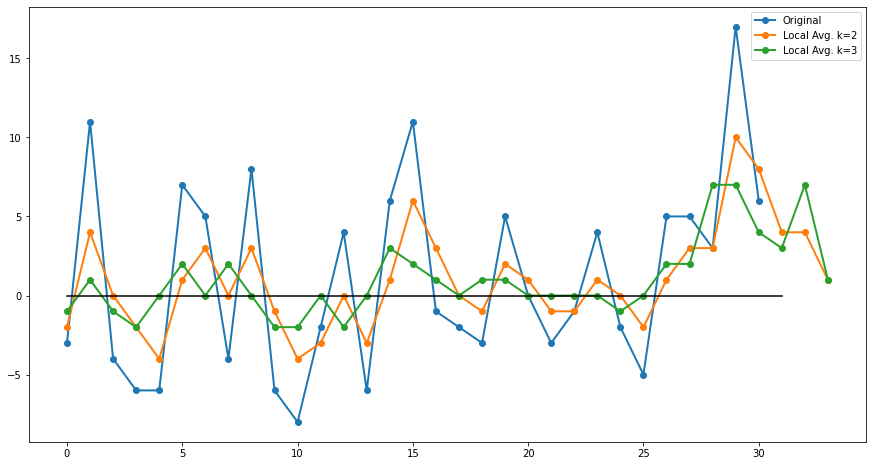

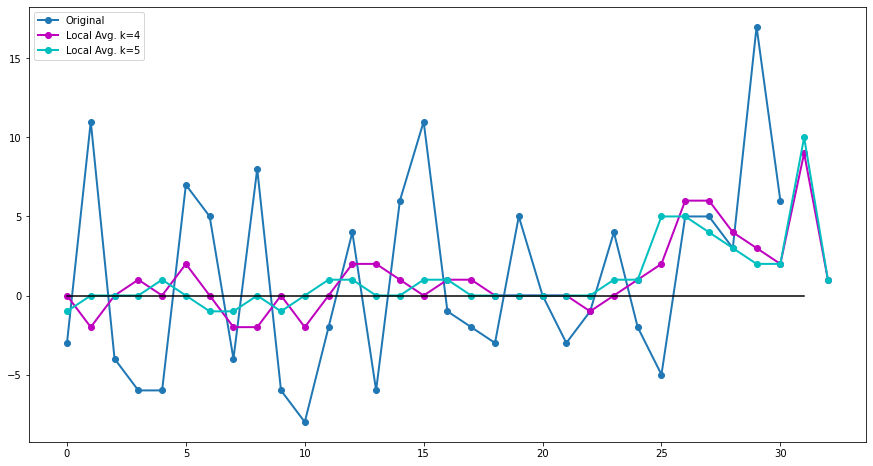

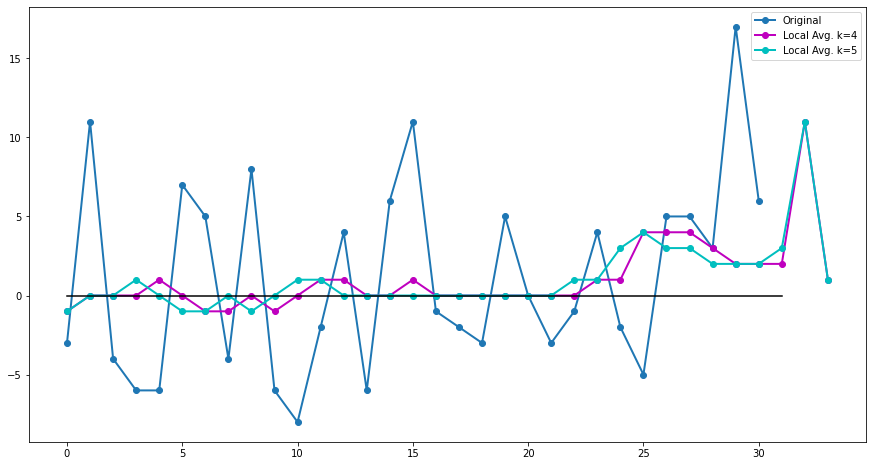

In [30]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,31,0)
df = DF_CLEAN
df_2 = read_csv("dfs/2020/k_greedy2")
df_3 = read_csv("dfs/2020/k_greedy3")
df_4 = read_csv("dfs/2020/k_greedy4")
df_5 = read_csv("dfs/2020/k_greedy5")
df_6 = read_csv("dfs/2020/k_greedy6")
df_7 = read_csv("dfs/2020/k_greedy7")

df_count = get_df_count(DF_CLEAN,start_date,end_date)
df_count_2 = get_df_count(df_2)
df_count_3 = get_df_count(df_3)
df_count_4 = get_df_count(df_4)
df_count_5 = get_df_count(df_5)
df_count_6 = get_df_count(df_6)
df_count_7 = get_df_count(df_7)

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'o',label='Original',linewidth=2)
plt.plot(list(df_count_2["Imbalance"]),'o',label='Local Avg. k=2',linewidth=2)
plt.plot(list(df_count_3["Imbalance"]),'o',label='Local Avg. k=3',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'o',label='Original',linewidth=2)
plt.plot(list(df_count_4["Imbalance"]),'mo',label='Local Avg. k=4',linewidth=2)
plt.plot(list(df_count_5["Imbalance"]),'co',label='Local Avg. k=5',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'-o',label='Original',linewidth=2)
plt.plot(list(df_count_6["Imbalance"]),'-mo',label='Local Avg. k=4',linewidth=2)
plt.plot(list(df_count_7["Imbalance"]),'-co',label='Local Avg. k=5',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

In [24]:
# def local_k_average(df,k=2,verbose=False):
#     df_resched = df.copy()
#     df_count = get_df_count(df_resched,fill_missing=True)
#     dates = df_count.index
#     num_days = len(dates)
#     for i in range(num_days):
#         k = int(min(num_days-i,k)) # Address the last k-1 problem. (More at the end) 
#         local_queue = list(range(i,i+k))
#         while (len(local_queue)>=2):
#             day1,day2,last = dates[local_queue[0]],dates[local_queue[1]],dates[local_queue[-1]]
#             df_count = get_df_count(df_resched,day1,last,fill_missing=True)
#             bal_val = int(np.average(df_count.loc[day1:last,"Imbalance"]))
#             df_resched = balance(df_resched,day1,day2,bal_val,verbose)
#             local_queue.pop(0)
#     return df_resched

In [27]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_time = pd.DataFrame(index=[2,3,4,5,6,7,10,14])

for k in df_time.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_average(df,k,verbose=False)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/2020/"+"k_"+str(k))
    df_time.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time.loc[k,"Time (s)"]))
    
    
df_time

k = 2 : 1.980385
k = 3 : 3.346550
k = 4 : 4.941319
k = 5 : 6.636155
k = 6 : 8.576653
k = 7 : 10.003294
k = 10 : 15.128634
k = 14 : 17.500678


Time (s)
2    1.980385
3    3.346550
4    4.941319
5    6.636155
6    8.576653
7   10.003294
10  15.128634
14  17.500678